# APPLY KMEANS ALGORITHM ON AMAZON FINE FOOD REVIEWS

In [2]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
# Tutorial about

# LOADING DATA

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape

Number of data points in our data (50000, 10)


(50000, 10)

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# PREPROCESSING

In [10]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'each', 'most', 'don', 'this', 'yours', 'between', 'such', 'nor', 'weren', 'off', "aren't", "needn't", "you're", 'can', "shouldn't", 'under', 'both', 'so', 'has', 'he', 'yourself', 'up', 'have', 'himself', 'were', 'other', 'themselves', "should've", 'they', 'was', "doesn't", 'than', 'how', 'his', "it's", 'at', 'i', 'hers', 'their', 'herself', 'did', 'out', 'she', "she's", 'it', 'after', 'ourselves', 'and', 's', 'him', 'further', 'just', 'then', 'o', 'some', 'shan', 'won', 'wasn', 'whom', 'very', 'we', 'here', 'no', 'hasn', 'who', 'its', 'do', 'itself', 'above', 'only', 'had', "didn't", "hadn't", 're', 'll', 'until', 'if', 'y', 'yourselves', 'needn', 'few', 'not', 'haven', 'mightn', 'the', "won't", 'where', 'below', 'but', 'in', 'am', 'for', 'more', 'of', 'been', 'aren', "wouldn't", 'them', 'why', 'didn', 'which', 'is', 'what', 'should', 'through', 'own', 've', "weren't", 'will', 'with', 'her', 'me', 'from', 'myself', 'you', 'doesn', 'does', 'our', 'theirs', 'an', "mightn't", 'over', "

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [12]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (46071, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...


In [13]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
time_sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...
28085,30628,B00008RCMI,A3AKWA5CWSKOOH,"Ilaxi S. Patel ""Editor, kidsfreesouls.com & A...",0,0,1,1068076800,Refreshing Mouth Freshner!,A tennis player hubby of mine got this pack on...,tenni player hubbi mine got pack rack opel cor...
39671,43130,B0000W2SZS,A2BETN6Y2DEFZ1,Catnip,11,11,1,1069459200,"Imparts wonderful, light flavor to dishes","I discovered these oils years ago, bought one ...",discov oil year ago bought one flavor thunders...


# [1]APPLYING KMEANS ON BOW

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features=1000)
bow= count_vect.fit_transform(time_sorted_data['CleanedText'].values)
bow.shape


(46071, 1000)

In [15]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
bow_std = sc.fit_transform(bow)
bow_std.shape

(46071, 1000)

In [16]:
num_clusters=[2,5,10,15,20,25,30,35,40,45,50]
num_clusters

[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [17]:
from sklearn.cluster import KMeans
loss=[]
for i in num_clusters:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(bow_std)
    loss.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
    

In [18]:
loss

[46038294.98865117,
 45383592.076933354,
 45114080.92246222,
 44860340.0619157,
 44594835.254732534,
 44360131.823065266,
 44098891.410819836,
 43935774.3641375,
 43843703.984164946,
 43708014.911249064,
 43537608.286872596]

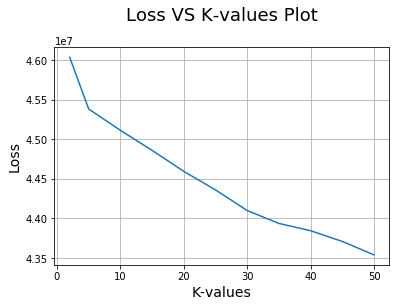

In [19]:
# Draw Loss VS K values plot
plt.plot(num_clusters, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()


optimal cluster value is 5

In [20]:
# Training the best model --
model = KMeans(n_clusters = 5, n_jobs = -1)
model.fit(bow_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
model.labels_[0:10]

array([0, 0, 0, 0, 4, 0, 0, 0, 0, 4], dtype=int32)

In [22]:
model.n_clusters

5

In [23]:
#Labels of each point
mydict = {i: np.where(model.labels_ == i)[0] for i in range(5)}
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [24]:
mydict

{0: array([    0,     1,     2, ..., 46068, 46069, 46070]),
 1: array([4898, 4930]),
 2: array([  315,   505,   848,  1033,  1121,  1211,  1709,  2324,  2547,
         2600,  2983,  2985,  3199,  3434,  3510,  3524,  3696,  4351,
         4490,  4515,  4519,  4520,  4521,  4523,  4534,  4536,  4537,
         4538,  4539,  4542,  4545,  4546,  4556,  4571,  4572,  4606,
         4615,  4632,  4687,  4692,  4701,  5170,  5331,  5506,  5510,
         5615,  5778,  5820,  6379,  6405,  8222,  8223,  8224,  8391,
         8467,  9035,  9395,  9431, 10614, 10934, 11232, 11480, 13247,
        13480, 15104, 15710, 16284, 16708, 16760, 17411, 17456, 17615,
        17639, 18271, 18576, 19830, 20312, 20449, 20593, 20699, 21089,
        22120, 22246, 23058, 24084, 26459, 28697, 29002, 29183, 29482,
        29951, 30986, 31704, 34055, 34224, 34708, 35078, 36220, 36248,
        36427, 37163, 39603, 39739, 39875, 39913, 42187, 42428, 42536,
        43650, 43996, 44375]),
 3: array([  669,  1163,  134

In [25]:
A=time_sorted_data['CleanedText'].values
A

array(['realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb',
       'receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor',
       'noth product bother link top page buy use chew gum lose flavor bedpost overnight andi alaska',
       ...,
       'love faucet husband instal one old hous current faucet leak told fix would buy one easi enough instal need assist time help hold thing place look great work great',
       'everyday coffe choic good around crowd pleaser green mountain sumatra would second choic nice hand',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'],
      dtype=object)

In [28]:
!pip install plotly

    100% |████████████████████████████████| 38.4MB 33kB/s  eta 0:00:01
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /home/siddharth19gwl/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [30]:
!pip install --upgrade wordcloud

Requirement already up-to-date: wordcloud in ./.local/lib/python2.7/site-packages
    100% |████████████████████████████████| 17.0MB 81kB/s  eta 0:00:01
Requirement already up-to-date: pillow in ./.local/lib/python2.7/site-packages (from wordcloud)


# PLOTTING WORDCLOUD FOR CLUSTER 1

In [26]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

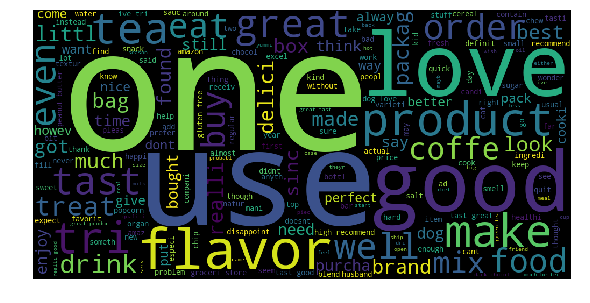

In [27]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER2

In [28]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[1]])))

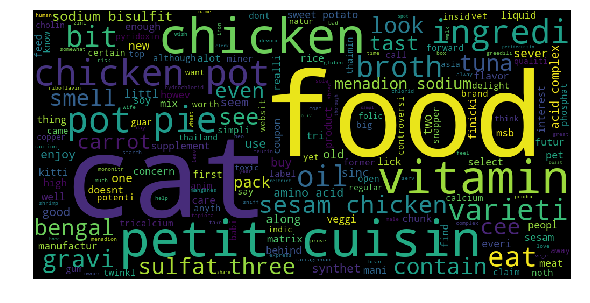

In [29]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER3

In [30]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[2]])))

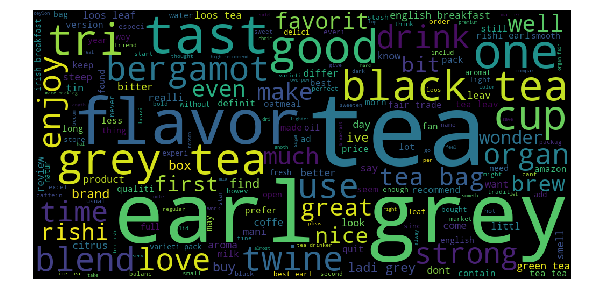

In [31]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER4

In [32]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[3]])))

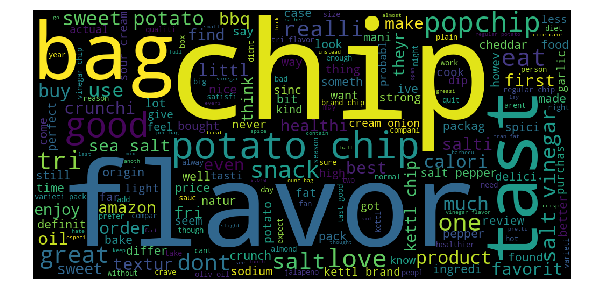

In [33]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER 5

In [34]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[4]])))

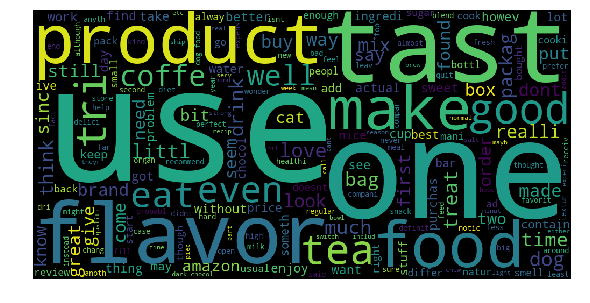

In [35]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [2] APPLYING KMEANS ON TFIDF

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=1000)
tfidf= tfidf_vect.fit_transform(time_sorted_data['CleanedText'].values)
tfidf.shape


(46071, 1000)

In [37]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidf_std = sc.fit_transform(tfidf)
tfidf_std.shape

(46071, 1000)

In [38]:
num_clusters=[2,5,10,15,20,25,30,35,40,45,50]
num_clusters

[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [39]:
from sklearn.cluster import KMeans
loss=[]
for i in num_clusters:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(tfidf_std)
    loss.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
    

In [40]:
loss

[45935565.32569304,
 45729210.11443693,
 45542490.421229996,
 45186176.204989955,
 44981417.13265233,
 44781441.69383983,
 44490218.9404129,
 44333125.5872705,
 44096747.58306228,
 43964752.56824097,
 43749911.84345737]

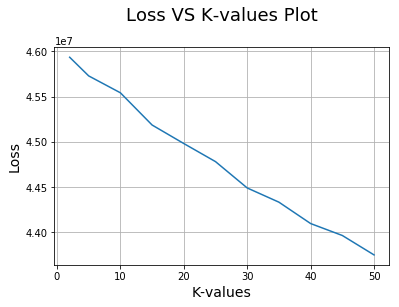

In [41]:
# Draw Loss VS K values plot
plt.plot(num_clusters, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()


Optimal cluster value is 5

In [42]:
# Training the best model --
model = KMeans(n_clusters = 5, n_jobs = -1)
model.fit(tfidf_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
#Labels of each point
mydict = {i: np.where(model.labels_ == i)[0] for i in range(5)}
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [44]:
A=time_sorted_data['CleanedText'].values
A

array(['realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb',
       'receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor',
       'noth product bother link top page buy use chew gum lose flavor bedpost overnight andi alaska',
       ...,
       'love faucet husband instal one old hous current faucet leak told fix would buy one easi enough instal need assist time help hold thing place look great work great',
       'everyday coffe choic good around crowd pleaser green mountain sumatra would second choic nice hand',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'],
      dtype=object)

# PLOTTING WORDCLOUD FOR CLUSTER1

In [45]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

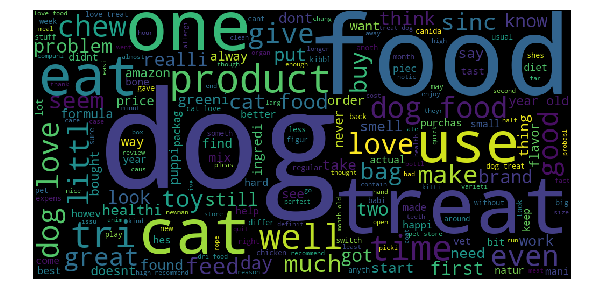

In [46]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER2

In [47]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[1]])))

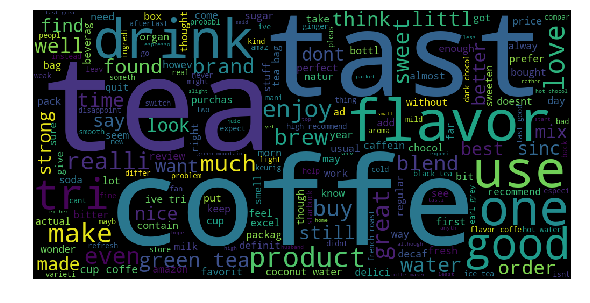

In [48]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER3

In [49]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[2]])))

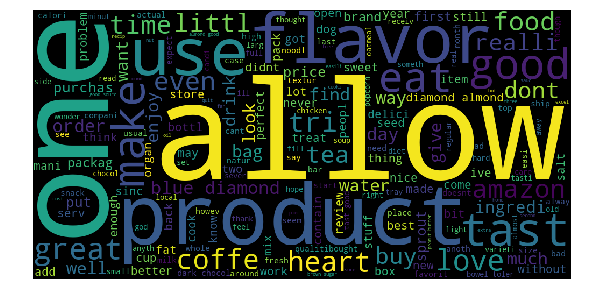

In [50]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER 4

In [51]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[3]])))

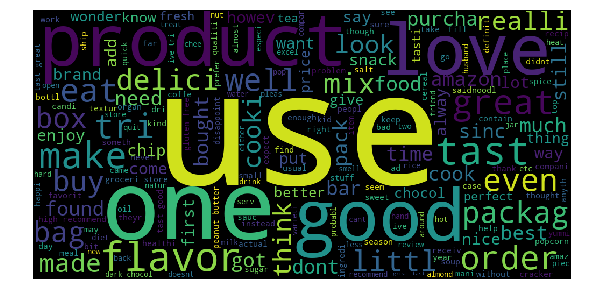

In [52]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER5

In [53]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[4]])))

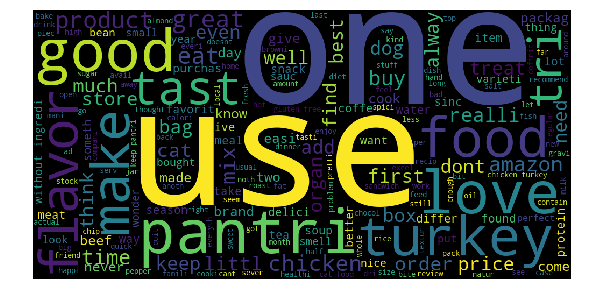

In [54]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [3] APPLY KMEANS ON W2V

In [87]:
i=0
list_of_sent=[]
for sent in time_sorted_data['CleanedText'].values:
    list_of_sent.append(sent.split())
    

In [88]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [89]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8683


In [90]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

46071
50


In [59]:
type(sent_vectors[0])

numpy.ndarray

In [60]:
sent_vectors[0:10]

[array([-0.03889039, -0.30895096,  0.06293714, -0.29359774, -0.06054202,
         0.22110263, -0.0467733 ,  0.19427962,  0.56159348, -0.24068606,
         0.16344011,  0.33950524,  0.17094536,  0.07933755,  0.56221796,
        -0.01394565, -0.72075743,  0.83143198, -0.03507648,  0.00182876,
         0.14945231,  0.86176337, -0.23661302,  0.38107476, -0.16427259,
        -0.20496898, -0.31613565,  0.2153973 , -0.00985498, -0.48649855,
        -0.44477811,  0.15380724,  0.06452627, -0.17473778, -0.23484564,
        -0.09435846,  0.432333  ,  0.17024834, -0.1863944 ,  0.08554902,
        -0.25264437, -0.13068147, -0.21417821, -0.09585177, -0.07113709,
         0.28347486, -0.04422056, -0.4555169 , -0.23064939,  0.00860672]),
 array([ 0.30130757, -0.40350075,  0.63129294,  0.07813136, -0.27018609,
         0.32094043,  0.09159667,  0.16418516,  0.3513658 , -0.34706791,
         0.04612168,  0.12891064, -0.01467699,  0.21593819,  0.23849429,
         0.05466806, -0.52803743,  0.78704115,  0

In [61]:
k=np.array(sent_vectors)

In [62]:
k[0:10]

array([[-3.88903856e-02, -3.08950959e-01,  6.29371425e-02,
        -2.93597744e-01, -6.05420229e-02,  2.21102626e-01,
        -4.67732976e-02,  1.94279621e-01,  5.61593483e-01,
        -2.40686061e-01,  1.63440106e-01,  3.39505236e-01,
         1.70945356e-01,  7.93375467e-02,  5.62217959e-01,
        -1.39456453e-02, -7.20757434e-01,  8.31431982e-01,
        -3.50764833e-02,  1.82875581e-03,  1.49452309e-01,
         8.61763367e-01, -2.36613020e-01,  3.81074762e-01,
        -1.64272587e-01, -2.04968982e-01, -3.16135646e-01,
         2.15397296e-01, -9.85498482e-03, -4.86498551e-01,
        -4.44778107e-01,  1.53807239e-01,  6.45262701e-02,
        -1.74737777e-01, -2.34845643e-01, -9.43584601e-02,
         4.32333001e-01,  1.70248345e-01, -1.86394401e-01,
         8.55490215e-02, -2.52644370e-01, -1.30681474e-01,
        -2.14178212e-01, -9.58517733e-02, -7.11370880e-02,
         2.83474863e-01, -4.42205611e-02, -4.55516895e-01,
        -2.30649394e-01,  8.60672394e-03],
       [ 3.01

In [63]:
type(k)

numpy.ndarray

In [64]:
type(sent_vectors)

list

In [65]:
type(list_of_sent)

list

In [66]:
type(list_of_sent[0])

list

In [91]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
w2v_std = sc.fit_transform(sent_vectors)
w2v_std.shape

(46071, 50)

In [92]:
num_clusters=[2,5,10,15,20,25,30,35,40,45,50]
num_clusters

[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [94]:
from sklearn.cluster import KMeans
loss=[]
for i in num_clusters:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(w2v_std)
    loss.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
    

In [95]:
loss

[2066294.9922757924,
 1704477.3037864584,
 1518972.7632420661,
 1429712.618183165,
 1358093.0348057607,
 1315901.7994267151,
 1281874.5263047381,
 1251455.323558314,
 1227785.6858393024,
 1207582.21336528,
 1189929.8130671503]

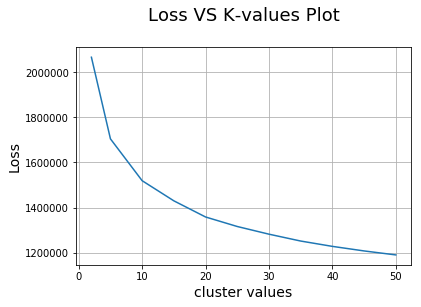

In [96]:
# Draw Loss VS K values plot
plt.plot(num_clusters, loss)
plt.xlabel('cluster values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()


so optimal cluster avlue is 20

In [97]:
# Training the best model --
model = KMeans(n_clusters = 20, n_jobs = -1)
model.fit(w2v_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [98]:
#Labels of each point
mydict = {i: np.where(model.labels_ == i)[0] for i in range(20)}
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [99]:
A=time_sorted_data['CleanedText'].values
A

array(['realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb',
       'receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor',
       'noth product bother link top page buy use chew gum lose flavor bedpost overnight andi alaska',
       ...,
       'love faucet husband instal one old hous current faucet leak told fix would buy one easi enough instal need assist time help hold thing place look great work great',
       'everyday coffe choic good around crowd pleaser green mountain sumatra would second choic nice hand',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'],
      dtype=object)

# PLOTTING WORDCLOUD FOR CLUSTER1

In [100]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

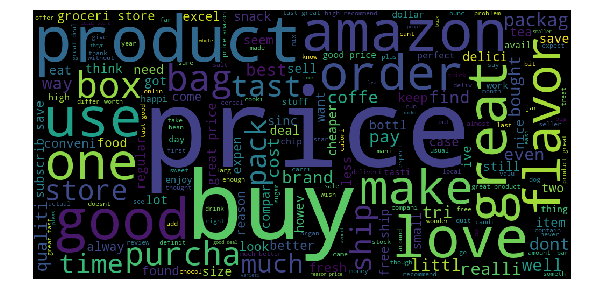

In [101]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER2

In [102]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[1]])))

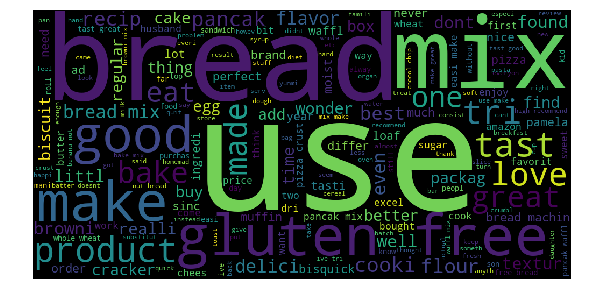

In [103]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER3

In [104]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[2]])))

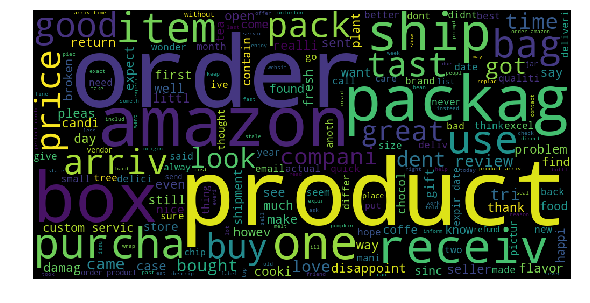

In [105]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

 Similarly we can plot for all remaining clusters

# [4] APPLY KMEANS ON TFIDF-W2V

In [106]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(time_sorted_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_vectors = []; 
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors

In [107]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidfw2v_std = sc.fit_transform(data)
tfidfw2v_std.shape

(46071, 50)

In [108]:
num_clusters=[2,5,10,15,20,25,30,35,40,45,50]
num_clusters

[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [109]:
from sklearn.cluster import KMeans
loss=[]
for i in num_clusters:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(tfidfw2v_std)
    loss.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
    

In [110]:
loss

[2103374.1747951196,
 1678187.244909519,
 1452773.0246581326,
 1317915.2238324038,
 1237294.389184015,
 1182453.0224093571,
 1138534.81647379,
 1101784.345773624,
 1074763.9339089226,
 1051512.5537593474,
 1019877.995384319]

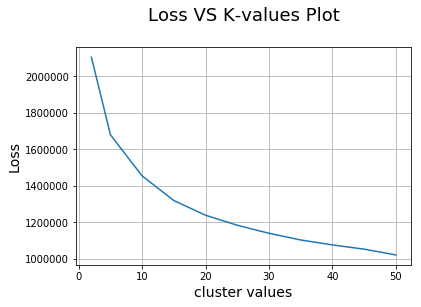

In [111]:
# Draw Loss VS K values plot
plt.plot(num_clusters, loss)
plt.xlabel('cluster values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()


so optimal cluster value is 20

In [112]:
# Training the best model --
model = KMeans(n_clusters = 20, n_jobs = -1)
model.fit(tfidfw2v_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [113]:
#Labels of each point
mydict = {i: np.where(model.labels_ == i)[0] for i in range(20)}
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [114]:
A=time_sorted_data['CleanedText'].values
A

array(['realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb',
       'receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor',
       'noth product bother link top page buy use chew gum lose flavor bedpost overnight andi alaska',
       ...,
       'love faucet husband instal one old hous current faucet leak told fix would buy one easi enough instal need assist time help hold thing place look great work great',
       'everyday coffe choic good around crowd pleaser green mountain sumatra would second choic nice hand',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'],
      dtype=object)

# PLOTTING WORDCLOUD FOR CLUSTER1

In [115]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

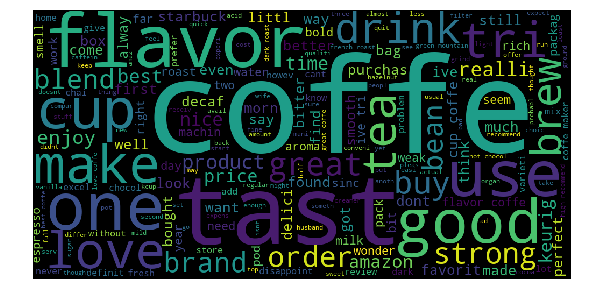

In [116]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER2

In [117]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[1]])))

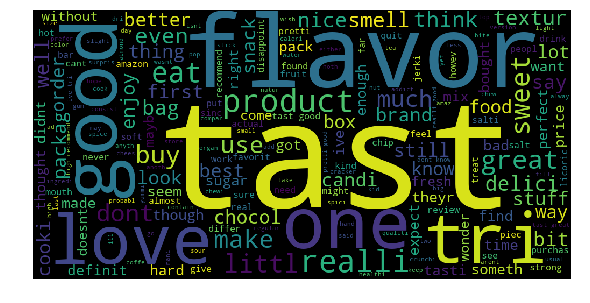

In [118]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER3

In [119]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[2]])))

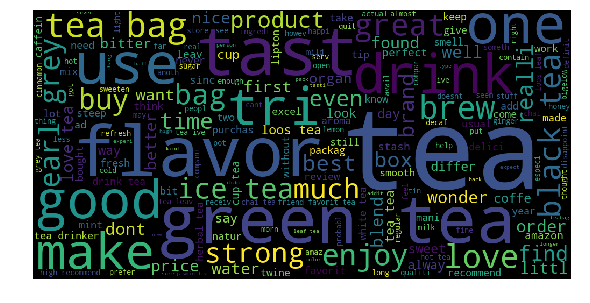

In [120]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER4

In [121]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[3]])))

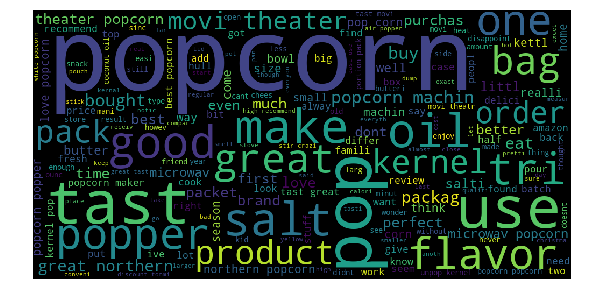

In [122]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# PLOTTING WORDCLOUD FOR CLUSTER5

In [123]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[4]])))

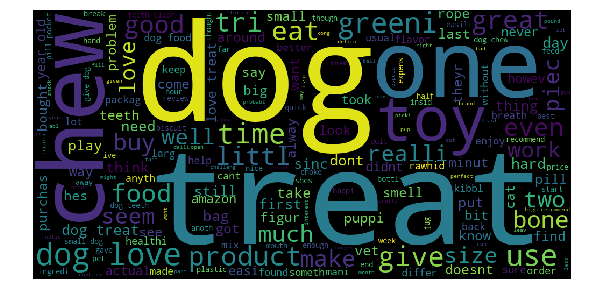

In [124]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 